Manuel Echave Mendez LU 1333/23

Agustin Ignacio Moguilevsky LU 951/23

Ian Pablo Marion LU 646/22

In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import geopandas as gpd
import seaborn as sns
import networkx as nx
import scipy

In [2]:
import funciones_TP1
import importlib
importlib.reload(funciones_TP1)  # Recarga el módulo con los cambios más recientes


<module 'funciones_TP1' from '/content/funciones_TP1.py'>

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [3]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

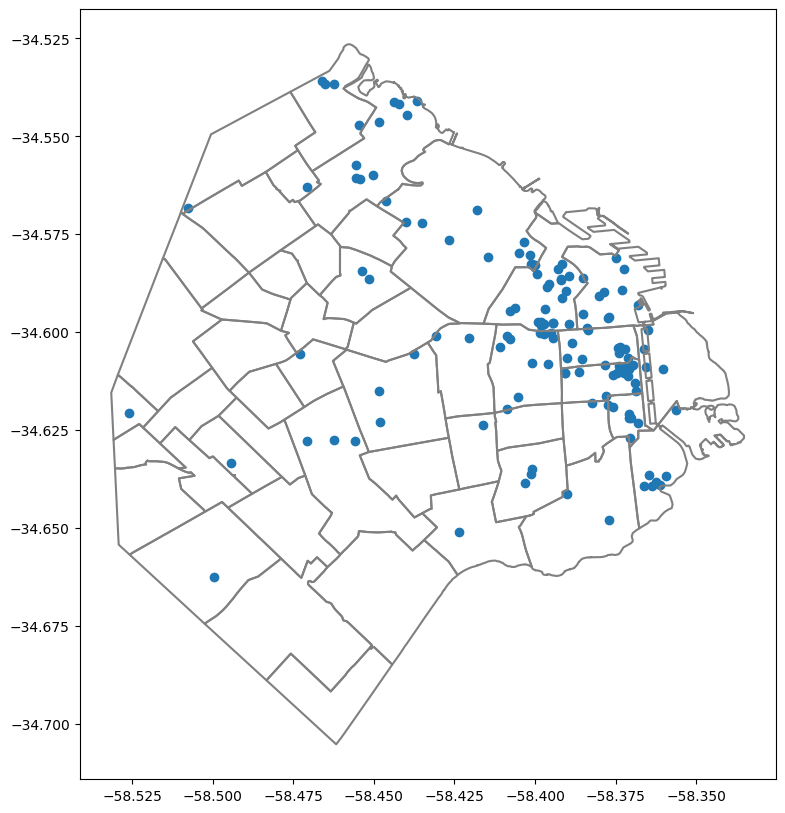

In [4]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [5]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [6]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [7]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

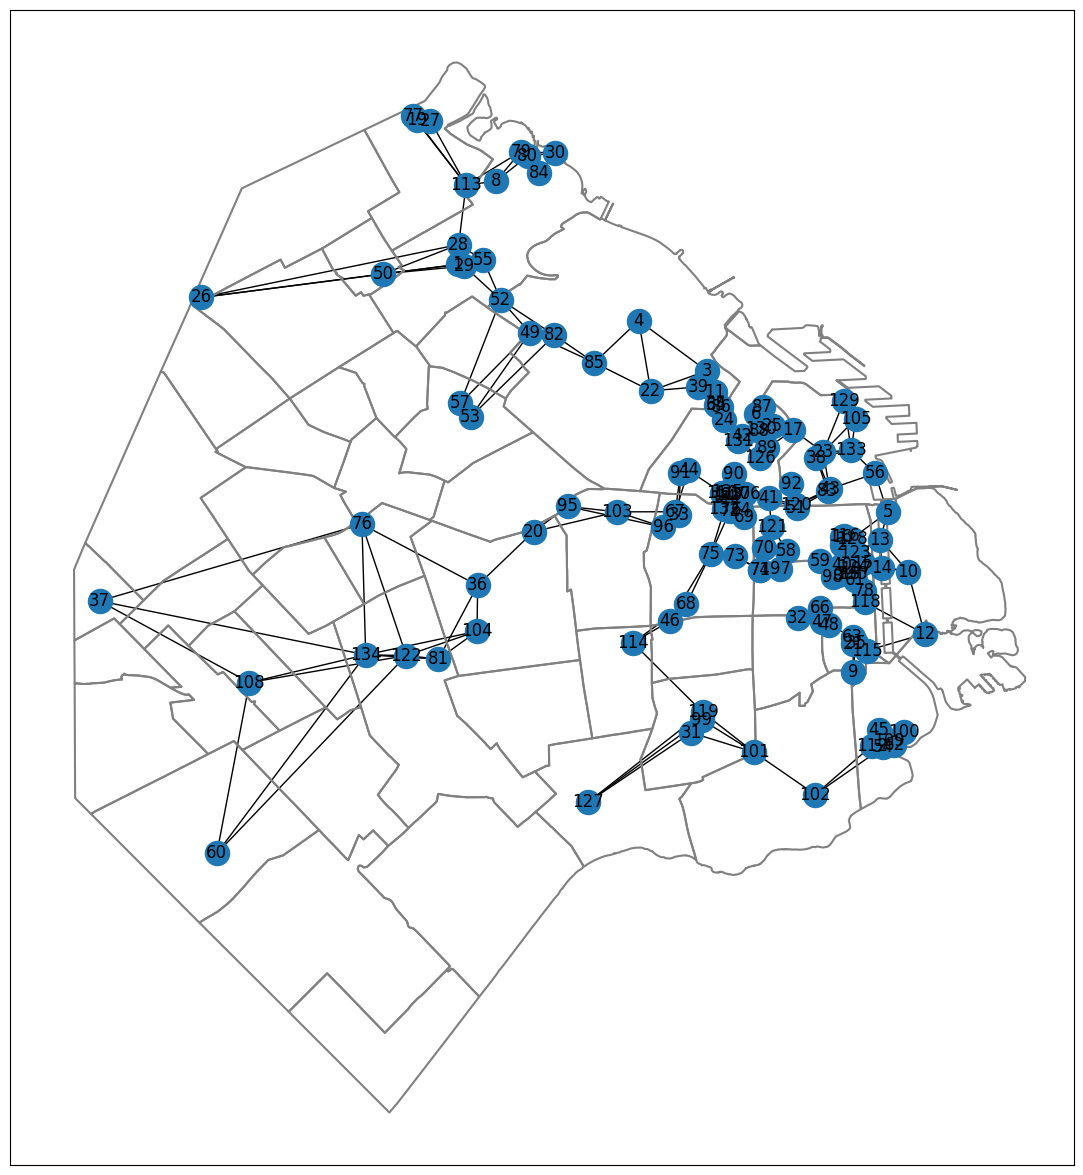

In [8]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Sabemos que:
$p=(1-α)Cp+\frac{\alpha}{N}1$

Podemos reorganizar esta ecuacion para agrupar los terminos con p:

$p-(1-α)Cp=\frac{\alpha}{N}1$

Sacamos $p$ como factor:

$(I-(1-α)C)p=\frac{\alpha}{N}1$

Por ultimo multiplicamos ambos lados por $\frac{N}{\alpha}$:

$\frac{N}{α}(I-(1-α)C)p=1$

Nos quedo lo que finalmente queriamos demostrar:

$Mp=1$

Porque $M=\frac{N}{α}(I-(1-α)C)$

## Punto 2:

En el punto 2 se nos pide dar la serie de condiciones para que la ecuación del punto anterior ($Mp = \mathbf{1}$) tenga una única solución.

Vemos que $p = M^{-1} \cdot \mathbf{1}$, por lo tanto $M$ debe ser no singular.

Esto es consistente matemáticamente ya que si $M$ es no singular, es un isomorfismo, lo que confirma que va a haber un único vector solución para cualquier sistema $Ax = b$, o en nuestro caso $Mp = \mathbf{1}$.

Para asegurar que la solución es única, no hay más restricciones que la mencionada.


**¿Se cumplen estas condiciones para la matriz $M$ tal como fue construida para los museos, cuando $0 < \alpha < 1$?**

Sabemos que $M = I - (1 - \alpha) C$, con $C$ estocástica. Eso quiere decir que $\|C\|_1 = 1$.

Si definimos $B = (1 - \alpha) C$, entonces:

$$
\|B\|_1 = (1 - \alpha)\|C\|_1 = 1 - \alpha
$$

Supongamos que $I - B$ es singular. Entonces existe un vector $x \neq 0$ tal que:

$$
(I - B)x = 0 \quad \Rightarrow \quad x = Bx
$$

Tomamos norma 1 de ambos lados:

$$
\|x\|_1 = \|Bx\|_1 \leq \|B\|_1 \cdot \|x\|_1 = (1 - \alpha) \cdot \|x\|_1
$$

Esto es un absurdo ya que implicaría que $\|x\|_1 \leq (1 - \alpha) \|x\|_1$ siendo $(1 - \alpha) < 1$.

Entonces, $I - B$ es no singular. Por lo tanto, M es inversible.


## Punto 3:

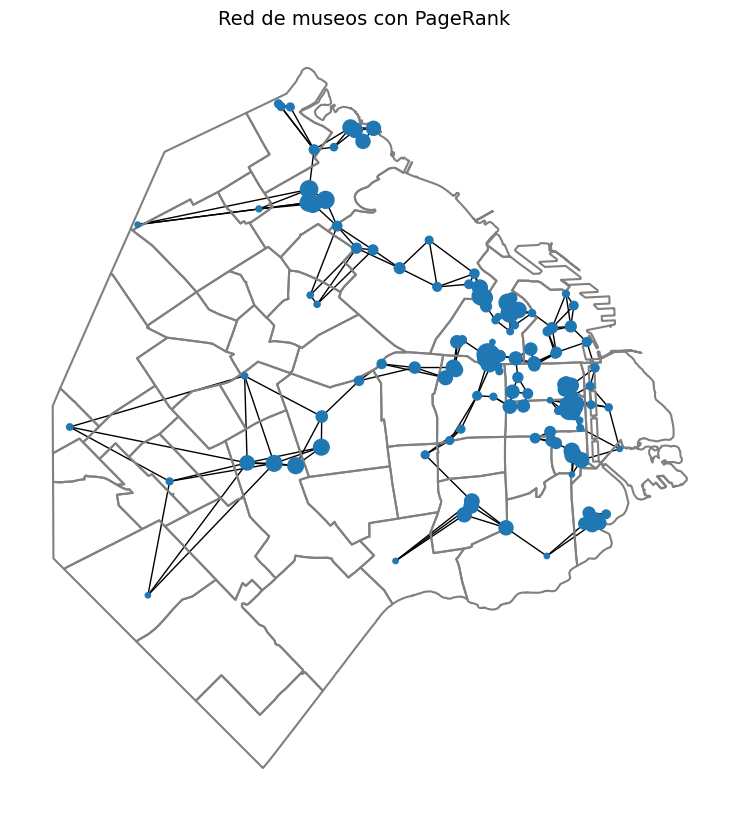

In [9]:
funciones_TP1.calcula_3a(D,G,museos,barrios)

Para $ m = 3 $ y $ \alpha = \frac{1}{5}$, observamos que los nodos con mayor tamaño representan museos más relevantes en la red según PageRank. Se destacan principalmente en zonas céntricas, lo que sugiere que están mejor conectados con el resto.


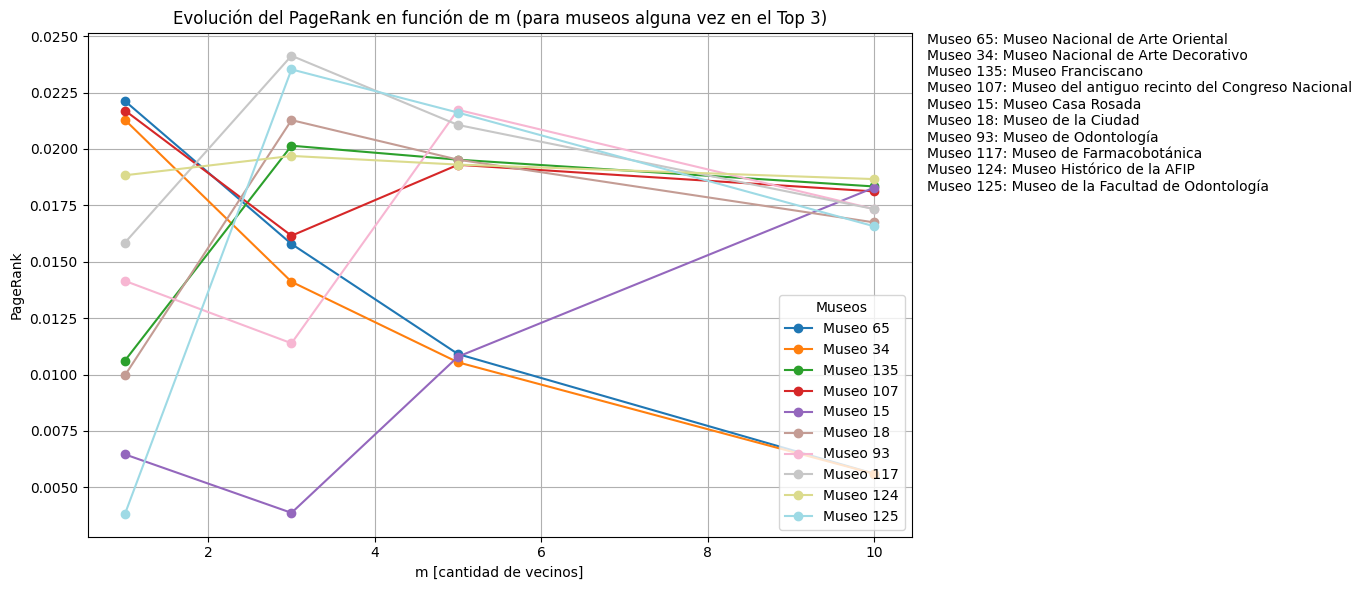

In [10]:
funciones_TP1.calcula_top3_m(D, museos)

El gráfico refleja cómo evoluciona el PageRank de los museos que alguna vez estuvieron en el top 3, en función de la cantidad de conexiones m. Algunos museos, como el Nacional de Arte Oriental, pierden protagonismo al aumentar m, mientras que otros, como el Museo del Congreso o el de la Ciudad, se fortalecen en redes más densas. Esto evidencia que la relevancia de cada museo depende fuertemente de la estructura general de la red.

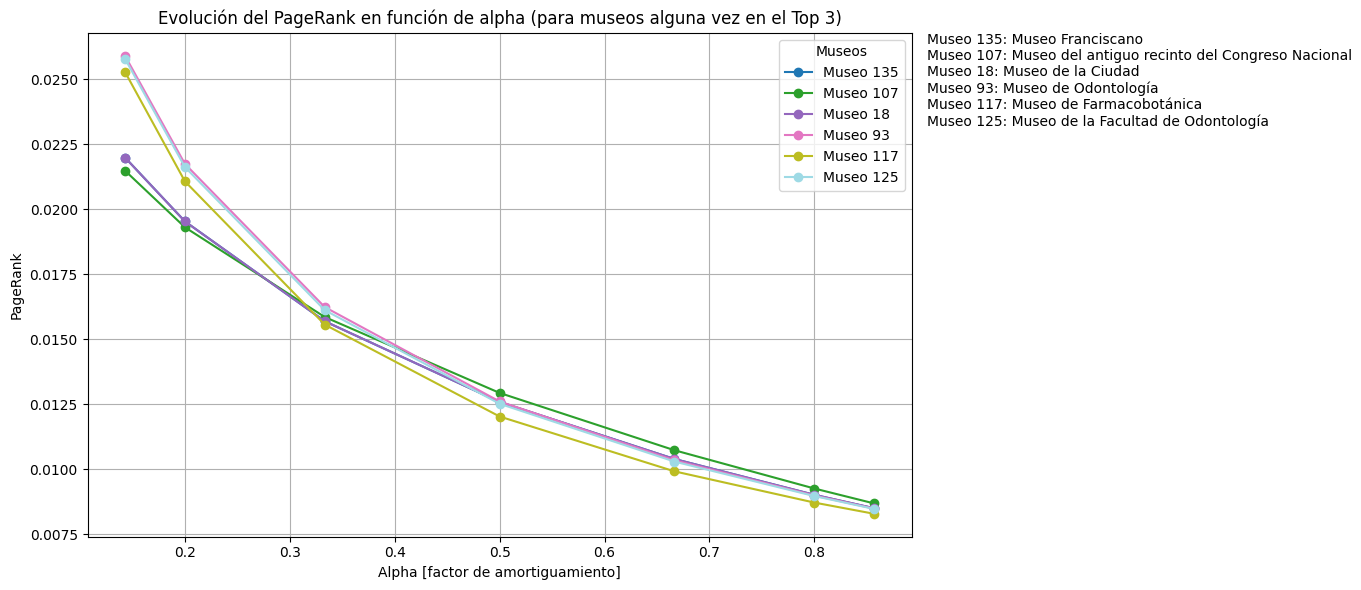

In [11]:
funciones_TP1.calcula_top3_alpha(D, museos)

A medida que aumenta α, el PageRank de los museos del top 3 disminuye progresivamente, siguiendo una tendencia bastante uniforme entre ellos. Esto sugiere que, al reducirse el componente aleatorio del algoritmo, se distribuye de forma más pareja la importancia en la red, y los museos pierden protagonismo relativo. Las diferencias entre ellos se achican, reflejando un comportamiento colectivo más que particular.

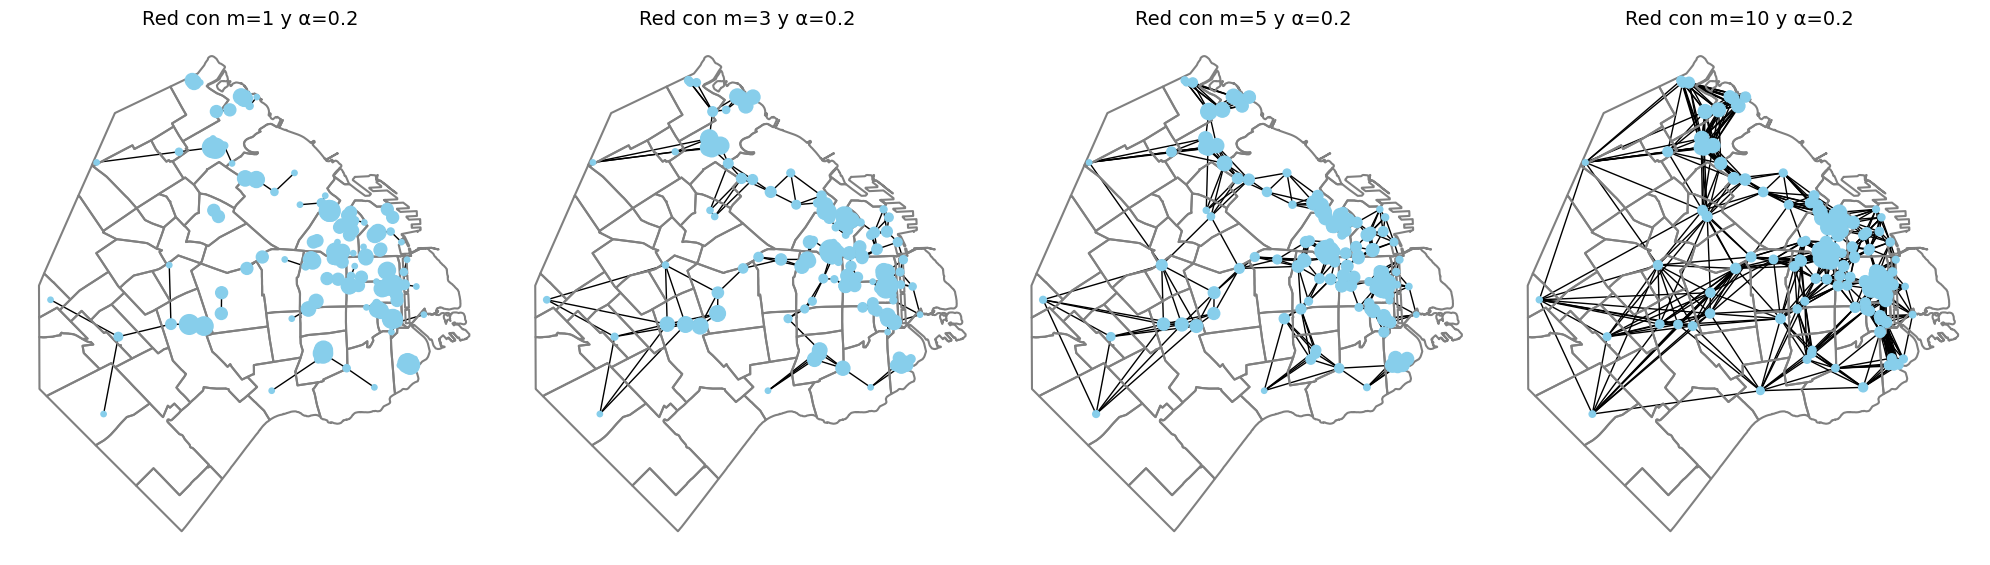

In [12]:
funciones_TP1.visualizar_red_m_variable(D,museos,barrios)

Al aumentar m, se refuerzan las conexiones y predominan las regiones centrales y noreste de CABA, como Recoleta y Palermo. Estas zonas concentran mayor PageRank y se vuelven estructuralmente más influyentes en la red.

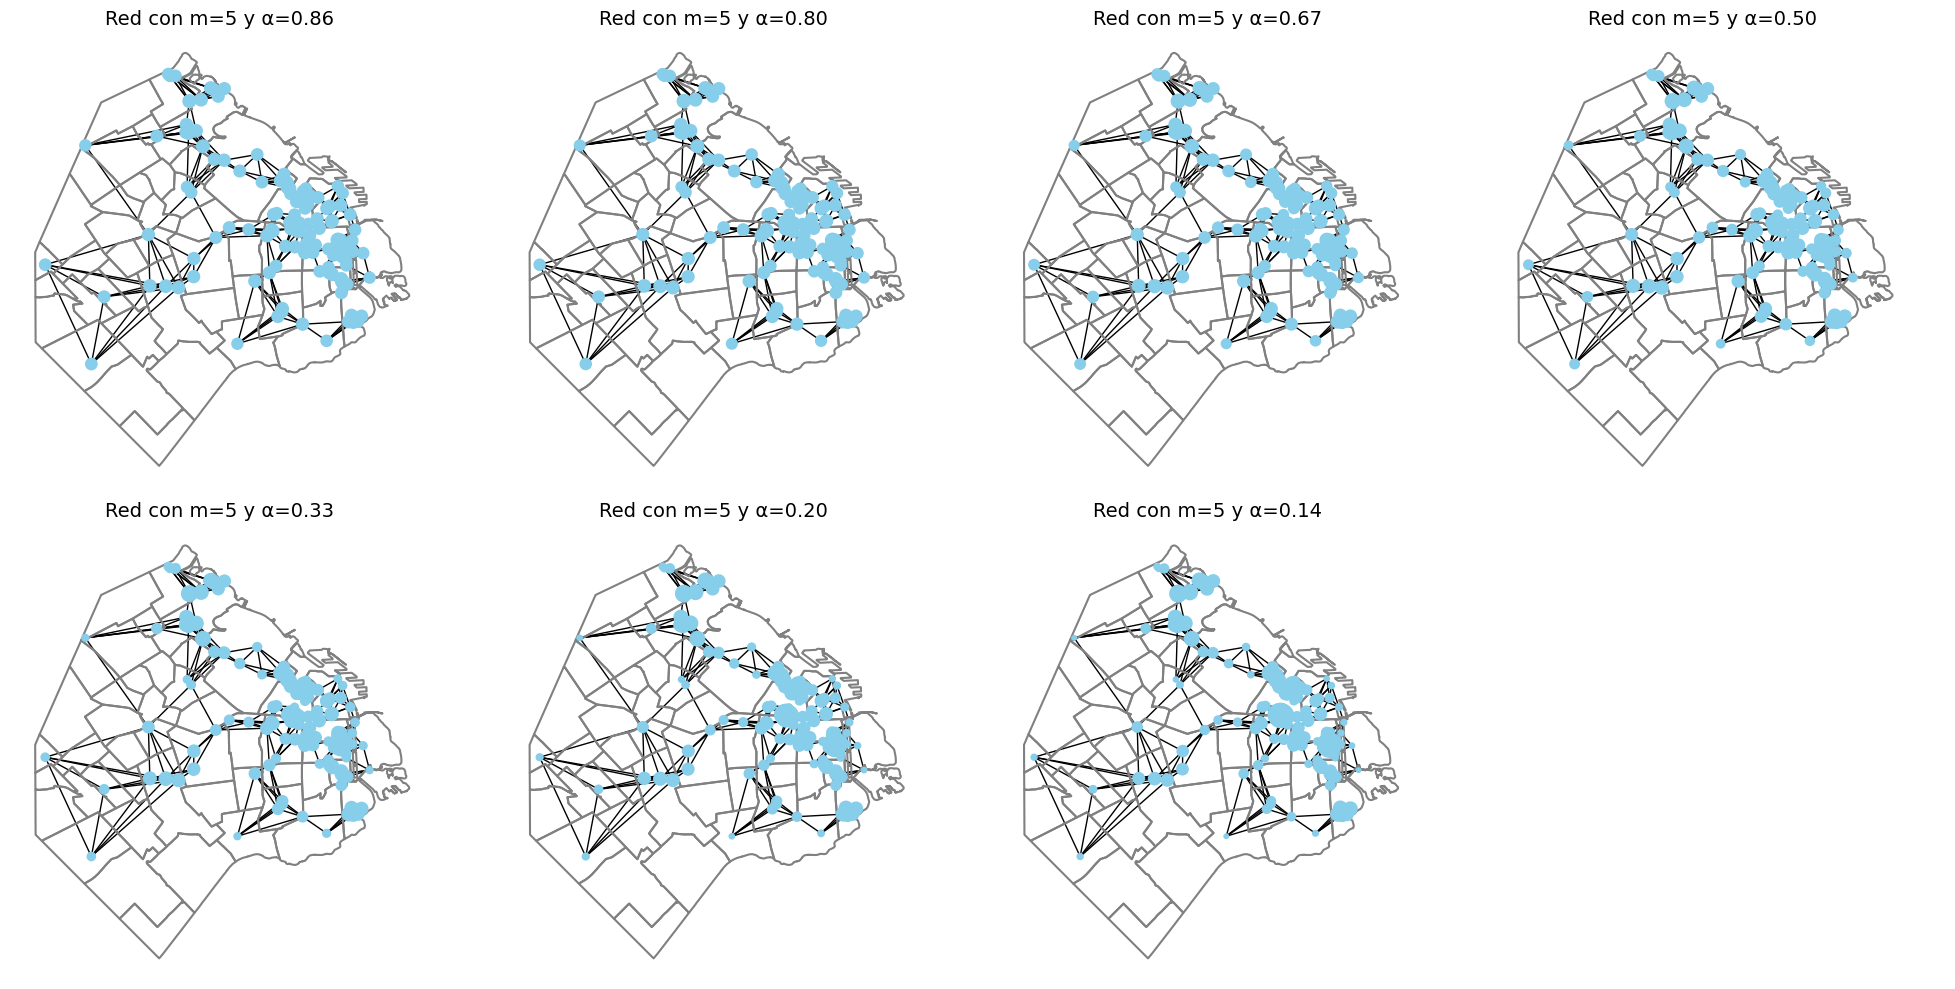

In [13]:
funciones_TP1.visualizar_red_alpha_variable(D,museos,barrios)

Al aumentar α, el algoritmo de PageRank se apoya más en la estructura de la red, haciendo que los museos más conectados cobren mayor importancia. Esto se refleja en que, con valores altos de α, las zonas del centro y norte de la ciudad (como Recoleta, Palermo o Microcentro) se vuelven predominantes, con nodos claramente más grandes. A medida que α disminuye, la importancia se distribuye de forma más pareja y se pierde esa jerarquía visible entre regiones. Con α bajos, la red se vuelve más homogénea y las diferencias entre nodos casi desaparecen.

## Punto 4:

Partimos de las siguientes hipótesis:

- Cada persona realiza $r$ visitas antes de abandonar la red.
- $\mathbf{v}$ es el vector que indica cuántas personas entraron inicialmente a cada museo.
- $\mathbf{w}$ es el vector que indica cuántas visitas totales recibió cada museo.
- $C$ es la matriz de transición de la red.


\
$C^k \mathbf{v}$ es el vector de distribución de visitas después de $k$ pasos, si las personas comenzaron en los museos según la distribución $\mathbf{v}$. Entonces:

$$
C^0 \mathbf{v} = \mathbf{v} \quad \text{(visitas iniciales)}
$$

$$
C^1 \mathbf{v} \quad \text{(visitas luego de un paso)}
$$

$$
\vdots
$$

$$
C^{r-1} \mathbf{v} \quad \text{(visitas luego de $r-1$ pasos)}
$$

La suma total de los terminos la representamos como:

$$
\sum_{k=0}^{r-1} C^k \mathbf{v}
$$

Esto da el total de visitas a cada museo, considerando que cada persona hace $r$ visitas. Es decir:

$$
\sum_{k=0}^{r-1} C^k \mathbf{v} = \mathbf{w}
$$
Por lo tanto:
$$
\mathbf{w} = \sum_{k=0}^{r-1} C^k \mathbf{v}
$$

$$
\Rightarrow \mathbf{w} = \left( \sum_{k=0}^{r-1} C^k \right) \mathbf{v} \quad
$$

$$
\Rightarrow \mathbf{w} = B \mathbf{v}, \quad \text{con} \quad B := \sum_{k=0}^{r-1} C^k
$$

$$
\Rightarrow \mathbf{v} = B^{-1} \mathbf{w} \quad \text{(siempre que $B$ sea invertible)}
$$

$$
\boxed{\mathbf{v} = \left( \sum_{k=0}^{r-1} C^k \right)^{-1} \mathbf{w}}
$$


## Punto 5:

In [14]:
r = 3
v, B = funciones_TP1.calcula_v(D,r)
visitas = funciones_TP1.calcula_norma_1(v)
print(visitas)

136605.0


In [15]:
# Para corroborar que el output dado tiene sentido
w = funciones_TP1.obtener_w()
w_sombrerito = B @ v
error = funciones_TP1.calcula_norma_1(w - w_sombrerito)  # Error absoluto
print("||w||_1 =",funciones_TP1.calcula_norma_1(w))
print("||w - Bv||_1 =", error)

||w||_1 = 409815.0
||w - Bv||_1 = 5.502442945726216e-11


## Análisis del resultado obtenido

Dado el valor de $r = 3$, resolvimos el sistema utilizando la función `calcula_v(D, r)`, la cual devuelve el vector $v$ y la matriz $B$ tal que:

$$
w = Bv \quad \Rightarrow \quad v = B^{-1}w
$$

Luego, calculamos el número total de visitas como la norma $1$ del vector $v$:

$$
\|v\|_1 = 136605.0
$$

Para verificar que el resultado tenga sentido, obtuvimos el vector $w$ utilizando la función `obtener_w()`, y calculamos el error absoluto entre el vector original y el reconstruido mediante $Bv$:

$$
\|w - Bv\|_1 = 5.502442945726216~e^{-11}
$$

Este valor es extremadamente pequeño, lo cual indica que la solución obtenida es numéricamente muy precisa.

También calculamos la norma $1$ del vector $w$:

$$
\|w\|_1 = 409815.0
$$

Este valor tiene sentido, ya que cada persona realizó exactamente $r = 3$ visitas. Por lo tanto, estimamos la cantidad de personas como:

$$
\frac{\|w\|_1}{r} = \frac{409815}{3} \approx 136605
$$
En resumen, el resultado es consistente con lo esperado y el error es despreciable.


## Punto 6:

Para obtener el numero de condicion de $B$, necesitamos calcular la norma 1 de B y la norma 1 de $B^{-1}$:


In [16]:
# Calculamos la norma 1 de B
B_norma_1 = funciones_TP1.calcula_norma_1(B)

print("||B||_1 =", B_norma_1)

# Calculamos B_inv

B_inv = funciones_TP1.inversaLU(B)

# Calculamos la norma 1 de B_inv

B_inv_norma_1 = funciones_TP1.calcula_norma_1(B_inv)

print("||B_inv||_1 =", B_inv_norma_1)

cond_1_B = B_norma_1 * B_inv_norma_1
print("cond_1(B) =", cond_1_B)

||B||_1 = 3.000000000000003
||B_inv||_1 = 1.6839237255550006
cond_1(B) = 5.051771176665007


## Análisis de la estabilidad del sistema y su número de condición

Se modela el número de visitas a los museos como $w = Bv$, donde:

- $w$ es el total de visitas recibidas por cada museo,
- $v$ es el número de visitantes únicos (las “primeras visitas”),
- y $B$ es una matriz que modela cuántas veces repite la visita un visitante en promedio.

Nuestro objetivo es estimar $v$ a partir de $w$, es decir, debemos resolver:

$$
v = B^{-1} w
$$

Calculamos el número de condición de $B$ en la norma 1:

$$
\|B\|_1 =3.000000000000003, \quad \|B^{-1}\|_1 = 1.6839237255550006
$$

Por lo tanto,

$$
\text{cond}_1(B) = \|B\|_1 \cdot \|B^{-1}\|_1 \approx 5.051771176665007
$$

Este valor nos indica que $B$ **no está mal condicionada**. De hecho, un número de condición cercano a 10 sugiere que el sistema es razonablemente estable frente a errores en los datos.



Ahora bien, se nos pide acotar el **error relativo en $v$**, dado un error relativo del 5% en $w$, es decir:

$$
\frac{\|w - \hat{w}\|_1}{\|w\|_1} = 0.05
$$

Aplicamos la desigualdad que relaciona los errores relativos:

$$
\frac{\|v - \hat{v}\|_1}{\|v\|_1} \leq \text{cond}_1(B) \cdot \frac{\|w - \hat{w}\|_1}{\|w\|_1}
$$

Reemplazando:

$$
\frac{\|v - \hat{v}\|_1}{\|v\|_1} \leq 5.051771176665007 \cdot 0.05 = 0.2526
$$

Esto quiere decir que **un error del 5% en los datos de entrada podría generar un error de hasta el 25.26% en el resultado**. Si bien no es una catástrofe, nos muestra que **el sistema amplifica el error de entrada**, aunque no de manera exagerada.


Este análisis nos permite afirmar que:

- El sistema **no es extremadamente sensible** a los errores,
- Pero aún así, **los errores pueden amplificarse**, por lo que es importante trabajar con datos lo más precisos posible.



# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

NameError: name 'p' is not defined

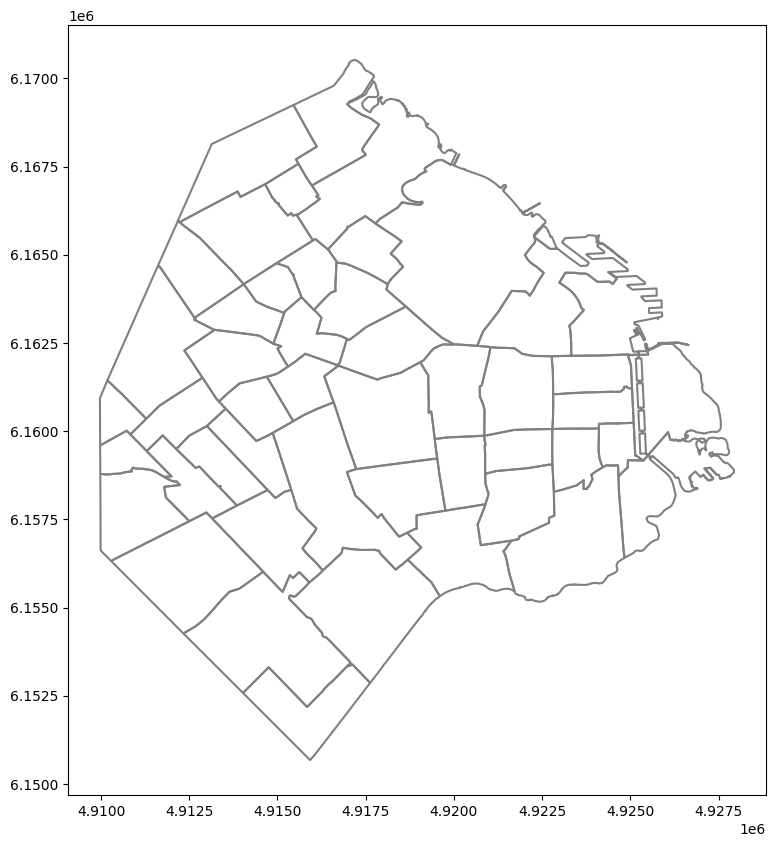

In [17]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = p
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres